In [1]:
%matplotlib inline


# Implement a Denoising Autoencoder


Use soundpy to implement a denoising autoencoder to clean noisy speech files.

To see how soundpy implements this, see `soundpy.builtin.denoiser_run`.

In [2]:
# to be able to import soundpy from parent directory:
import os
package_dir = '../'
os.chdir(package_dir)

Let's import soundpy, assuming it is in your working directory:



In [3]:
import soundpy as sp;
import IPython.display as ipd

## Prepare for Implementation: Data Organization

### Set model pathway


Currently, this expects a model saved with weights, with a .h5 extension.
(See `model` below)



**soundpy offers a pre-trained denoiser.** 

*(Scroll to bottom for more info on what the denoiser was trained on)*

In [4]:
# Use function 'string2pathlib' to turn string path into pathlib object 
# This allows flexibility across operating systems
model = sp.string2pathlib('audiodata/models/denoiser/example_denoiser_stft.h5')
# as pathlib object, can easily navigate pathway:
model_dir = model.parent

What is in this folder?



In [5]:
files = list(model_dir.glob('*.*'))
for f in files:
    print(f.name)

example_denoiser_stft.h5
log_extraction_settings.csv
log.csv


### Load feature extraction settings

For implementation, it is important that *the same features are extracted from new data as those the model was trained on.*

You can save how features were extracted different ways.

If soundpy extracts features for you, a 'log_extraction_settings.csv' 
file will be saved, which includes relevant feature settings for implementing 
the model. See soundpy.feats.save_features_datasets

In [6]:
feat_settings = sp.utils.load_dict(
    model_dir.joinpath('log_extraction_settings.csv'))
for key, value in feat_settings.items():
    print(key, ' --> ', value)
    # change objects that were string to original format
    import ast
    try:
        feat_settings[key] = ast.literal_eval(value)
    except ValueError:
        pass
    except SyntaxError:
        pass

dur_sec  -->  3
feature_type  -->  stft noisy
feat_type  -->  stft
complex_vals  -->  True
sr  -->  22050
num_feats  -->  177
n_fft  -->  352
win_size_ms  -->  16
frame_length  -->  352
percent_overlap  -->  0.5
window  -->  hann
frames_per_sample  -->  11
labeled_data  -->  False
visualize  -->  True
input_shape  -->  (35, 11, 177)
desired_shape  -->  (385, 177)
use_librosa  -->  True
center  -->  True
mode  -->  reflect
subsection_data  -->  True
divide_factor  -->  10


### For the purposes of plotting, let's use some of the settings defined:



In [7]:
feature_type = feat_settings['feat_type']
sr = feat_settings['sr']

## Provide a new audiofile for the denoiser to denoise!

### We'll use a speech signal provided by soundpy and add white noise to it

In [8]:
speech = sp.string2pathlib('audiodata/python.wav')
s, sr = sp.loadsound(speech, sr=sr)
ipd.Audio(s,rate=sr)

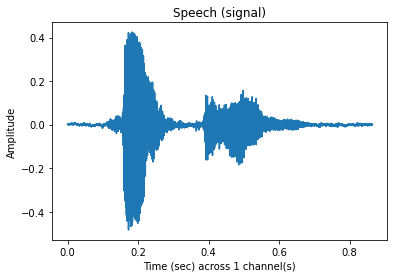

In [9]:
sp.plotsound(s, sr=sr, feature_type='signal', title='Speech (signal)')

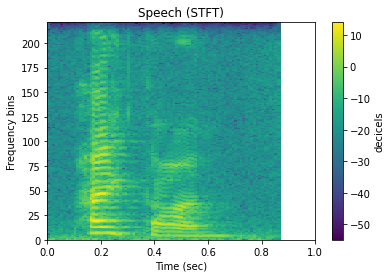

In [10]:
sp.plotsound(s, sr=sr, feature_type=feature_type, title='Speech ({})'.format(feature_type.upper()))

## Add white noise: stationary noise

In [11]:
snr = 10

In [12]:
s_wn = sp.augment.add_white_noise(s, sr=sr, snr=snr)

/home/airos/Projects/github/a-n-rose/Python-Sound-Tool/soundpy/feats.py:563: UserWarning: 
  warnings.warn(msg)
/home/airos/Projects/github/a-n-rose/Python-Sound-Tool/soundpy/dsp.py:2463: UserWarning: 
  warnings.warn(msg)


In [13]:
ipd.Audio(s_wn,rate=sr)

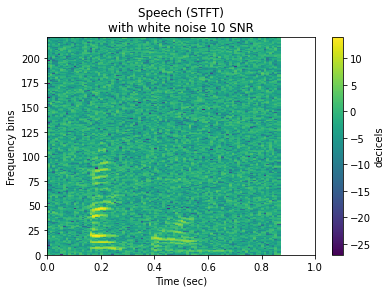

In [14]:
sp.plotsound(s_wn, sr=sr, feature_type=feature_type, title='Speech ({})\nwith white noise {} SNR'.format(feature_type.upper(), snr))

# Built-In Denoiser Functionality

We just need to feed the model path, the noisy sample path, and 
the feature settings dictionary we looked at above.



In [15]:
y, sr = sp.denoiser_run(model, s_wn, feat_settings)

## How does the denoised speech sound?


In [16]:
ipd.Audio(y,rate=sr)

## Compare with Wiener Filter

In [17]:
s_wf, sr = sp.filtersignal(s_wn, sr=sr)
ipd.Audio(s_wf, rate=sr)

/home/airos/Projects/github/a-n-rose/Python-Sound-Tool/soundpy/builtin.py:145: UserWarning: 

If possible, perhaps use 8000, 16000, 41000, or 48000 sample rate instead.

  'perhaps use 8000, 16000, 41000, or 48000 sample rate instead.\n')


## Compared with the noisy signal

In [18]:
ipd.Audio(s_wn,rate=sr)

## Compared with the clean signal

In [19]:
ipd.Audio(s,rate=sr)

## How does is the denoised speech look? 



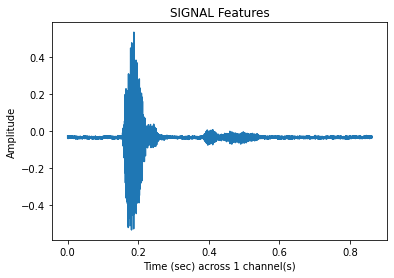

In [20]:
sp.plotsound(y, sr=sr, feature_type = 'signal')

### STFT features of the denoised speech



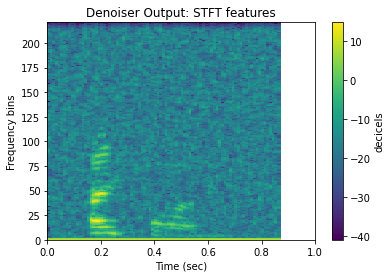

In [21]:
sp.plotsound(y, sr=sr, feature_type = 'stft', energy_scale = 'power_to_db',
               title = 'Denoiser Output: STFT features')

### STFT features of the Wiener filtered version of the audio:

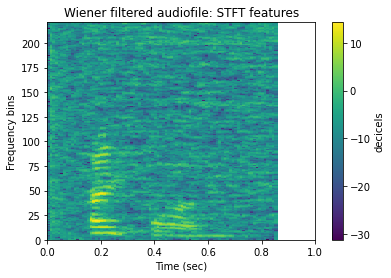

In [22]:
sp.plotsound(s_wf, sr=sr, feature_type = 'stft', energy_scale = 'power_to_db',
               title = 'Wiener filtered audiofile: STFT features')

### STFT features of the noisy version of the audio:



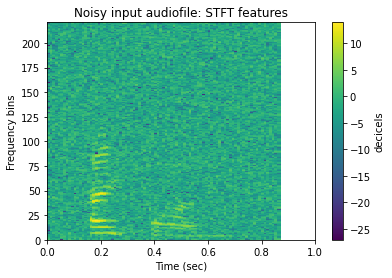

In [23]:
sp.plotsound(s_wn, sr=sr, feature_type = 'stft', energy_scale = 'power_to_db',
               title = 'Noisy input audiofile: STFT features')

### STFT features of the clean version of the audio:



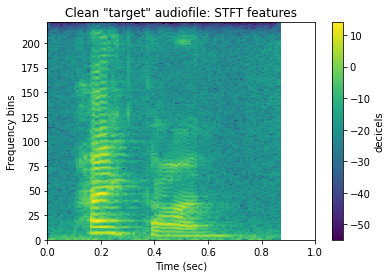

In [24]:
sp.plotsound(s, sr=sr, feature_type = 'stft', energy_scale = 'power_to_db',
               title = 'Clean "target" audiofile: STFT features')

# Try with non-stationary noise: car horn!

In [25]:
horn = sp.string2pathlib('audiodata/car_horn.wav')
h, sr = sp.loadsound(horn, sr=sr)

In [26]:
ipd.Audio(h,rate=sr)

# Add the car horn to speech: 20 SNR

In [27]:
s_h, snr = sp.dsp.add_backgroundsound(s, h, sr=sr, snr = 20, total_len_sec=3, stationary_noise = False, wrap = True)

/home/airos/Projects/github/a-n-rose/Python-Sound-Tool/soundpy/feats.py:563: UserWarning: 
  warnings.warn(msg)
/home/airos/Projects/github/a-n-rose/Python-Sound-Tool/soundpy/dsp.py:2463: UserWarning: 
  warnings.warn(msg)
/home/airos/Projects/github/a-n-rose/Python-Sound-Tool/soundpy/dsp.py:640: UserWarning: 

  warnings.warn(msg)


In [28]:
ipd.Audio(s_h,rate=sr)

## Apply the Denoiser

In [29]:
y_h, sr = sp.denoiser_run(model, s_h, feat_settings)

In [30]:
ipd.Audio(y_h,rate=sr)

## Compare with Wiener Filter

In [31]:
y_h_wf, sr = sp.filtersignal(y_h, sr=sr)

/home/airos/Projects/github/a-n-rose/Python-Sound-Tool/soundpy/builtin.py:145: UserWarning: 

If possible, perhaps use 8000, 16000, 41000, or 48000 sample rate instead.

  'perhaps use 8000, 16000, 41000, or 48000 sample rate instead.\n')


In [32]:
ipd.Audio(y_h_wf,rate=sr)

# Add the car horn to speech: 10 SNR

In [43]:
s_h_10, snr = sp.dsp.add_backgroundsound(s, h, sr=sr, snr = 10, total_len_sec=3, stationary_noise = False, wrap = True)

In [44]:
ipd.Audio(s_h_10,rate=sr)

## Apply the denoiser

In [45]:
y_h_10_denoiser, sr = sp.denoiser_run(model, s_h_10, feat_settings)

In [46]:
ipd.Audio(y_h_10_denoiser,rate=sr)

## Compare with Wiener Filter

In [47]:
y_h_wf, sr = sp.filtersignal(s_h_10, sr=sr)

In [48]:
ipd.Audio(y_h_wf,rate=sr)

# In sum

The denoiser did pretty well with stationary noise. It was not trained much on non-stationary noise, such as a car honk. **Might it perform better if so?**

Note: the model was trained on <a href='https://depts.washington.edu/phonlab/resources/uwnu/uwnu1/'>speech</a> corrupted by the following three background sounds, at various snr levels:

In [33]:
traffic = sp.string2pathlib('audiodata/background_samples/traffic.wav')
t, sr = sp.loadsound(traffic, sr=sr)
ipd.Audio(t,rate=sr)

In [34]:
fridge = sp.string2pathlib('audiodata/background_samples/fridge.wav')
f, sr = sp.loadsound(fridge, sr=sr)
ipd.Audio(f,rate=sr)

In [35]:
cafe = sp.string2pathlib('audiodata/background_samples/cafe.wav')
c, sr = sp.loadsound(cafe, sr=sr)
ipd.Audio(c,rate=sr)